## Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import glob
import os
from scipy.signal import medfilt

In [36]:
# helper functions
def smooth_reward_curve(x, y):
    # Halfwidth of our smoothing convolution
    halfwidth = min(31, int(np.ceil(len(x) / 30)))
    k = halfwidth
    xsmoo = x[k:-k]
    ysmoo = np.convolve(y, np.ones(2 * k + 1), mode='valid') / \
        np.convolve(np.ones_like(y), np.ones(2 * k + 1), mode='valid')
    downsample = max(int(np.floor(len(xsmoo) / 1e3)), 1)
    return xsmoo[::downsample], ysmoo[::downsample]

def fix_point(x, y, interval):
    np.insert(x, 0, 0)
    np.insert(y, 0, 0)

    fx, fy = [], []
    pointer = 0

    ninterval = int(max(x) / interval + 1)

    for i in range(ninterval):
        tmpx = interval * i

        while pointer + 1 < len(x) and tmpx > x[pointer + 1]:
            pointer += 1

        if pointer + 1 < len(x):
            alpha = (y[pointer + 1] - y[pointer]) / \
                (x[pointer + 1] - x[pointer])
            tmpy = y[pointer] + alpha * (tmpx - x[pointer])
            fx.append(tmpx)
            fy.append(tmpy)

    return fx, fy

def load_data(indir, smooth, bin_size):
    datas = []
    infiles = glob.glob(os.path.join(indir, '*.monitor.csv'))

    for inf in infiles:
        with open(inf, 'r') as f:
            f.readline()
            f.readline()
            for line in f:
                tmp = line.split(',')
                t_time = float(tmp[2])
                tmp = [t_time, int(tmp[1]), float(tmp[0])]
                datas.append(tmp)

    datas = sorted(datas, key=lambda d_entry: d_entry[0])
    result = []
    timesteps = 0
    for i in range(len(datas)):
        result.append([timesteps, datas[i][-1]])
        timesteps += datas[i][1]

    if len(result) < bin_size:
        return [None, None]

    x, y = np.array(result)[:, 0], np.array(result)[:, 1]

    if smooth == 1:
        x, y = smooth_reward_curve(x, y)

    if smooth == 2:
        y = medfilt(y, kernel_size=9)

    x, y = fix_point(x, y, bin_size)
    return [x, y]

def load_data2(datas, smooth, bin_size):
    result = []
    timesteps = 0
    for i in range(len(datas)):
        result.append([timesteps, datas[i][-1]])
        timesteps += datas[i][1]

    if len(result) < bin_size:
        return [None, None]

    x, y = np.array(result)[:, 0], np.array(result)[:, 1]

    if smooth == 1:
        x, y = smooth_reward_curve(x, y)

    if smooth == 2:
        y = medfilt(y, kernel_size=9)

    x, y = fix_point(x, y, bin_size)
    return [x, y]


In [41]:
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf',  # blue-teal
    '#8ddd8d',  # light cooked asparagus green
    '#f9b272',  # light safety orange
    '#84ccff'   # light muted blue
]

In [8]:
def _plot(folder, game, name, num_steps=2000000, bin_size=100, smooth=1):
    tx, ty = load_data(folder, smooth, bin_size)

    fig = plt.figure()
    plt.plot(tx, ty, label="{}".format(name))

    tick_fractions = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1.0])
    ticks = tick_fractions * num_steps
    tick_names = ["{:.0e}".format(tick) for tick in ticks]
    plt.xticks(ticks, tick_names)
    plt.xlim(0, num_steps * 1.01)

    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')

    plt.title(game)
    plt.legend(loc=4)
#    plt.show()
#    plt.draw()
    return tx, ty

## Add your scripts

### Plot the HalfCheetah plot, 2M timesteps

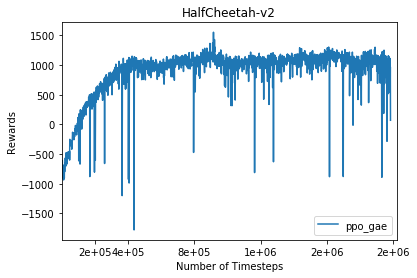

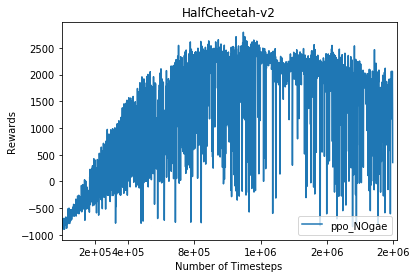

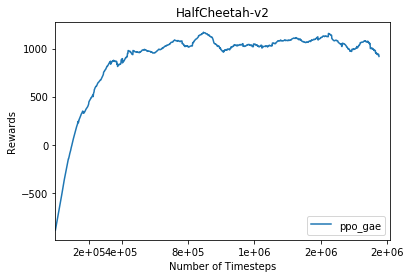

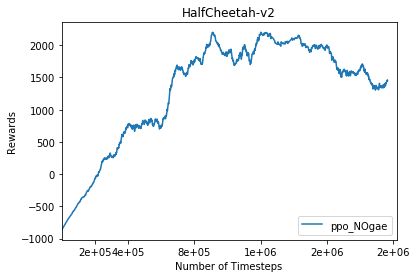

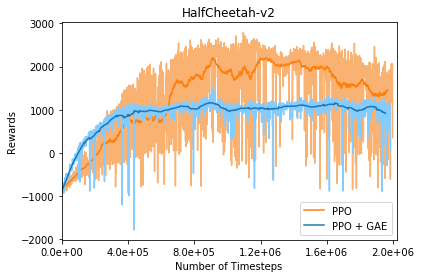

In [28]:
# import data
num_steps = 2000000
game = "HalfCheetah-v2"
ppoGae_x, ppoGae_y = _plot("results/halfCheetah_ppo_gae_2M", game, "ppo_gae", bin_size=10, smooth=0)
ppoNo_x, ppoNo_y = _plot("results/halfCheetah_nogae_2M", game, "ppo_NOgae", bin_size=10, smooth=0)
SppoGae_x, SppoGae_y = _plot("results/halfCheetah_ppo_gae_2M", game, "ppo_gae", bin_size=100, smooth=1)
SppoNo_x, SppoNo_y = _plot("results/halfCheetah_nogae_2M", game, "ppo_NOgae", bin_size=100, smooth=1)

plt.figure()
plt.plot(ppoNo_x, ppoNo_y, color=colors[-2])
plt.plot(SppoNo_x, SppoNo_y, color=colors[1], label="PPO")
plt.plot(ppoGae_x, ppoGae_y, color=colors[-1])
plt.plot(SppoGae_x, SppoGae_y, color=colors[0], label="PPO + GAE")

tick_fractions = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ticks = tick_fractions * num_steps
tick_names = ["{:.1e}".format(tick) for tick in ticks]
plt.xticks(ticks, tick_names)
plt.xlim(0, num_steps * 1.01)

plt.xlabel('Number of Timesteps')
plt.ylabel('Rewards')

plt.title(game)
plt.legend(loc=4)
plt.savefig('halfCheetah.png', dpi = 900)
plt.show()

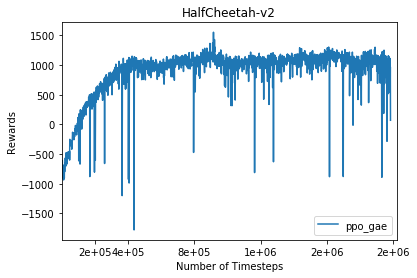

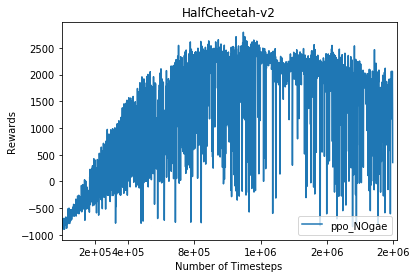

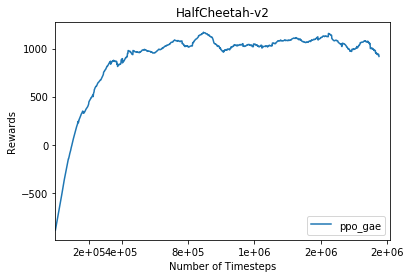

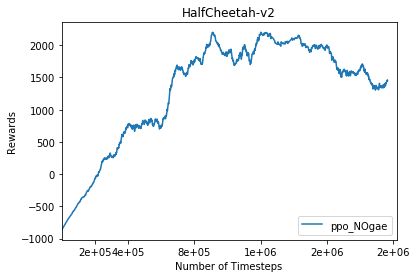

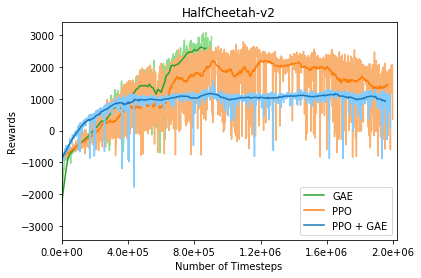

[-2260.887670392644, -1871.6885450215723, -1482.4894196505006, -1093.290294279429, -830.8575940848539, -736.1213353958887, -672.5473993443353, -612.4025055421848, -549.9123546995007, -494.9372210557313, -444.3974527722872, -409.83369693722176, -369.5095641798085, -320.1224203921267, -281.7278741799925, -222.10881132237125, -184.4958299691274, -116.2293527856913, -63.7667197087692, -8.153148279788459, 58.020855652921654, 102.66802729341696, 157.08990252328823, 234.88886012595526, 293.0944012163724, 295.9370320304082, 290.89766283197946, 359.9196853047396, 433.5213986707334, 503.1795670466163, 559.6179319118799, 697.1398389665108, 711.4675423301165, 778.2543962062103, 722.776318199193, 709.4731361419276, 695.1529556406225, 719.1817085085985, 802.691717275064, 850.9867660490299, 874.208576522324, 1000.5599360025701, 1066.9417828689952, 1156.128904230035, 1206.107729475279, 1297.2581652557344, 1323.6671654986942, 1400.2763479016478, 1409.2258081548682, 1409.169816340302, 1412.6825797773445

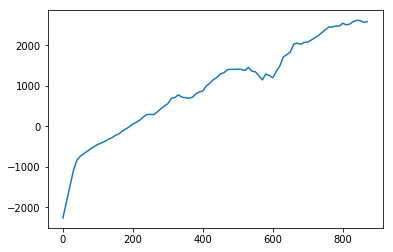

In [50]:
# import data
num_steps = 2000000
game = "HalfCheetah-v2"
ppoGae_x, ppoGae_y = _plot("results/halfCheetah_ppo_gae_2M", game, "ppo_gae", bin_size=10, smooth=0)
ppoNo_x, ppoNo_y = _plot("results/halfCheetah_nogae_2M", game, "ppo_NOgae", bin_size=10, smooth=0)
SppoGae_x, SppoGae_y = _plot("results/halfCheetah_ppo_gae_2M", game, "ppo_gae", bin_size=100, smooth=1)
SppoNo_x, SppoNo_y = _plot("results/halfCheetah_nogae_2M", game, "ppo_NOgae", bin_size=100, smooth=1)

import pickle

with open('test_rewards.pkl', 'rb') as f:
    test_rewards = pickle.load(f)
x = []
for i in range(len(test_rewards)):
    x.append(i*1000)
datas = []
for i in range(len(test_rewards)):
    datas.append([x[i], 1, test_rewards[i]])
Sx, Stest_rewards = load_data2(datas, smooth=1, bin_size = 10)
Sxx = [j*1000 for j in Sx]
plt.figure()
plt.plot(x, test_rewards, color=colors[-3])

plt.plot(ppoNo_x, ppoNo_y, color=colors[-2])
plt.plot(Sxx, Stest_rewards, color=colors[2], label="GAE")
plt.plot(SppoNo_x, SppoNo_y, color=colors[1], label="PPO")
plt.plot(ppoGae_x, ppoGae_y, color=colors[-1])
plt.plot(SppoGae_x, SppoGae_y, color=colors[0], label="PPO + GAE")


tick_fractions = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ticks = tick_fractions * num_steps
tick_names = ["{:.1e}".format(tick) for tick in ticks]
plt.xticks(ticks, tick_names)
plt.xlim(0, num_steps * 1.01)

plt.xlabel('Number of Timesteps')
plt.ylabel('Rewards')

plt.title(game)
plt.legend(loc=4)
plt.savefig('halfCheetah.png', dpi = 900)
plt.show()

plt.plot(Sx, Stest_rewards)

print(Stest_rewards)

### Plot the PPO vs ACKTR plot

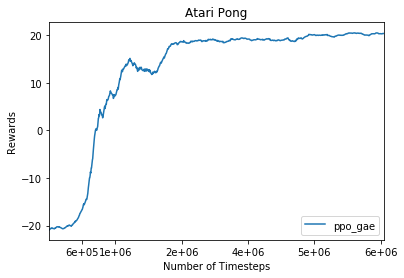

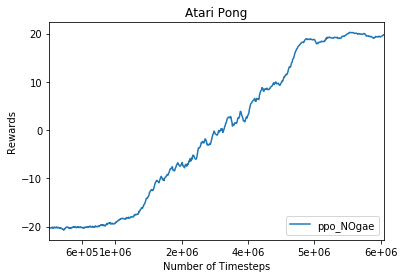

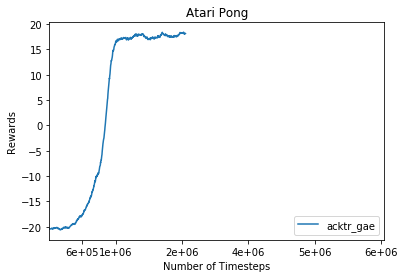

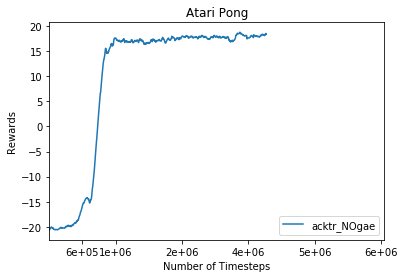

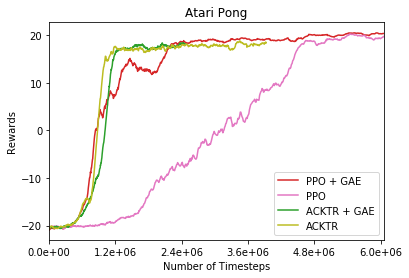

In [30]:
# import data
num_steps = 6000000
game = "Atari Pong"
ppoGae_x, ppoGae_y = _plot("results/ppo/ppo_gae_6M", game, "ppo_gae", num_steps)
ppoNo_x, ppoNo_y = _plot("results/ppo/ppo_nogae_6M", game, "ppo_NOgae", num_steps)
akGae_x, akGae_y = _plot("results/acktr/w_gae", game, "acktr_gae", num_steps)
akNo_x, akNo_y = _plot("results/acktr/no_gae", game, "acktr_NOgae", num_steps)

plt.figure()
plt.plot(ppoGae_x, ppoGae_y, color=colors[3], label="PPO + GAE")
plt.plot(ppoNo_x, ppoNo_y, color=colors[6], label="PPO")
plt.plot(akGae_x, akGae_y, color=colors[2], label="ACKTR + GAE")
plt.plot(akNo_x, akNo_y, color=colors[8], label="ACKTR")

tick_fractions = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ticks = tick_fractions * num_steps
tick_names = ["{:.1e}".format(tick) for tick in ticks]
plt.xticks(ticks, tick_names)
plt.xlim(0, num_steps * 1.01)

plt.xlabel('Number of Timesteps')
plt.ylabel('Rewards')

plt.title(game)
plt.legend(loc=4)
plt.savefig('ppo_vs_acktr.png', dpi = 900)
plt.show()

### Different seeds, PPO

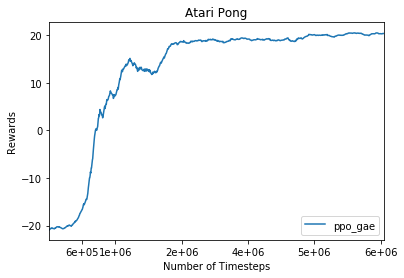

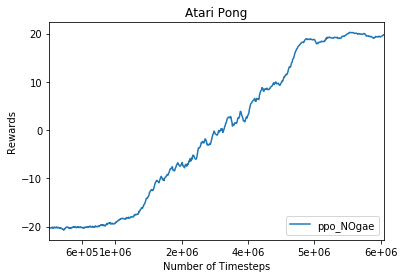

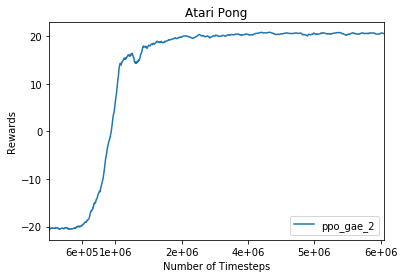

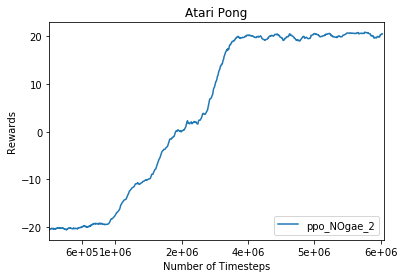

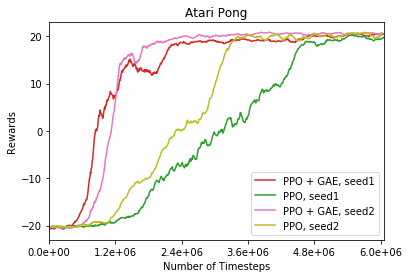

In [22]:
# import data
num_steps = 6000000
game = "Atari Pong"
ppoGae_x1, ppoGae_y1 = _plot("results/ppo/ppo_gae_6M", game, "ppo_gae", num_steps)
ppoNo_x1, ppoNo_y1 = _plot("results/ppo/ppo_nogae_6M", game, "ppo_NOgae", num_steps)
ppoGae_x2, ppoGae_y2 = _plot("results/ppo/ppo_gae_6M_seed3", game, "ppo_gae_2", num_steps)
ppoNo_x2, ppoNo_y2 = _plot("results/ppo/ppo_nogae_6M_seed3", game, "ppo_NOgae_2", num_steps)

plt.figure()
plt.plot(ppoGae_x1, ppoGae_y1, color=colors[3], label="PPO + GAE, seed1")
plt.plot(ppoNo_x1, ppoNo_y1, color=colors[2], label="PPO, seed1")
plt.plot(ppoGae_x2, ppoGae_y2, color=colors[6], label="PPO + GAE, seed2")
plt.plot(ppoNo_x2, ppoNo_y2, color=colors[8], label="PPO, seed2")

tick_fractions = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ticks = tick_fractions * num_steps
tick_names = ["{:.1e}".format(tick) for tick in ticks]
plt.xticks(ticks, tick_names)
plt.xlim(0, num_steps * 1.01)

plt.xlabel('Number of Timesteps')
plt.ylabel('Rewards')

plt.title(game)
plt.legend(loc=4)
plt.savefig('ppo_seeds.png', dpi = 600)
plt.show()

### Different seeds, ACKTR

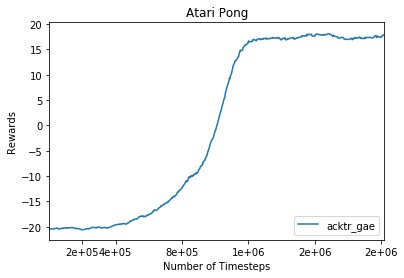

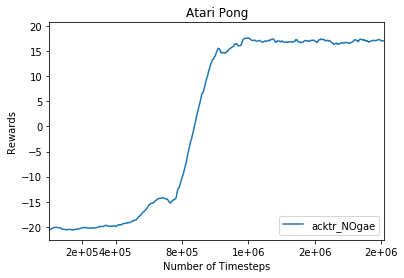

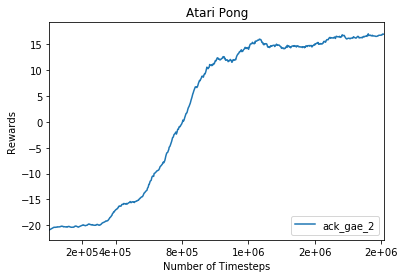

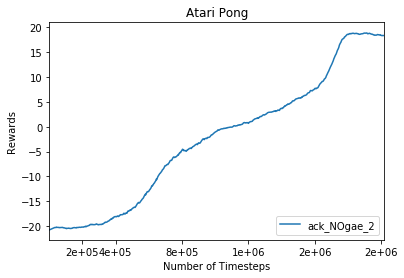

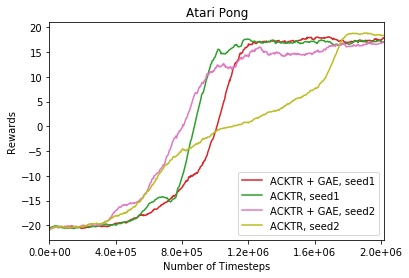

In [21]:
# import data
num_steps = 2000000
game = "Atari Pong"
akGae_x1, akGae_y1 = _plot("results/acktr/w_gae", game, "acktr_gae", num_steps)
akNo_x1, akNo_y1 = _plot("results/acktr/no_gae", game, "acktr_NOgae", num_steps)
akGae_x2, akGae_y2 = _plot("results/acktr/ack_gae_seed3", game, "ack_gae_2", num_steps)
akNo_x2, akNo_y2 = _plot("results/acktr/ack_no_gae_seed3", game, "ack_NOgae_2", num_steps)

plt.figure()
plt.plot(akGae_x1, akGae_y1, color=colors[3], label="ACKTR + GAE, seed1")
plt.plot(akNo_x1, akNo_y1, color=colors[2], label="ACKTR, seed1")
plt.plot(akGae_x2, akGae_y2, color=colors[6], label="ACKTR + GAE, seed2")
plt.plot(akNo_x2, akNo_y2, color=colors[8], label="ACKTR, seed2")

tick_fractions = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ticks = tick_fractions * num_steps
tick_names = ["{:.1e}".format(tick) for tick in ticks]
plt.xticks(ticks, tick_names)
plt.xlim(0, num_steps * 1.01)

plt.xlabel('Number of Timesteps')
plt.ylabel('Rewards')

plt.title(game)
plt.legend(loc=4)
plt.savefig('acktr_seeds.png', dpi = 600)
plt.show()